Import the iris data from the UCI repository and display a summary of the data.

In [9]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
filepath = 'C:/Users/tom/Documents/datasets/irises/iris.csv'
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'] 
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']


try:
    # Have we saved a local copy of the data?
    data = pd.read_csv(filepath, header=0)
except:
    # No local copy, so let's download the data and save it to file
    data = pd.read_csv(url, names=column_names, header=None)
    data.to_csv(filepath, index=False)

classes = data['class'].unique()
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Now let's quickly look at correlations between the 4 numeric features.

In [2]:
print(data.corr())

              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000


Now colour code the classes and plot all the 2-dimensional projections of the data.

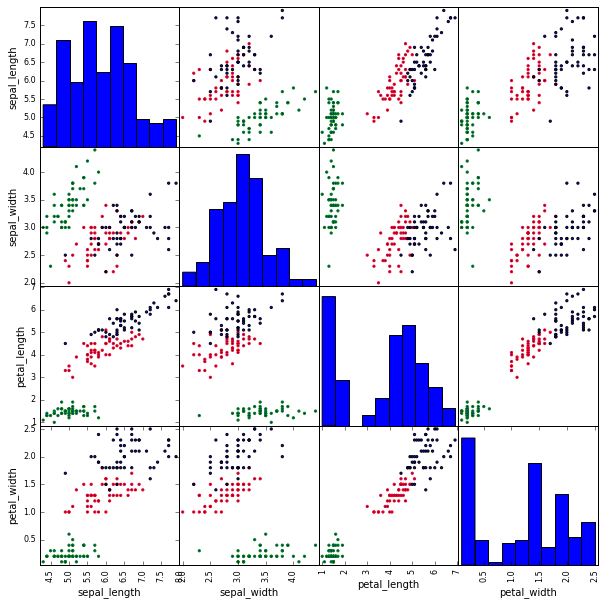

In [3]:
%matplotlib inline
class_colours = DataFrame(list(zip(classes, ['g', 'r', 'k'])), columns=['class', 'colour'])
scatter_colours = pd.merge(data, class_colours)['colour']
scatter_axes = pd.scatter_matrix(data, color=scatter_colours, figsize=(10,10), alpha=10)


Let's use a decision tree to model the data

In [4]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydot

# Prepare input and target data ready to feed to the model
inputs = data[feature_names]
targets = data['class']

# Fit a decision tree model to the data
model = DecisionTreeClassifier(criterion='entropy')
model.fit(inputs, targets)
print(model)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


How does the tree perform on the training data?

In [5]:
# Make predictions
expected = targets
predicted = model.predict(inputs)

# Summarise the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      1.00      1.00        50
 Iris-virginica       1.00      1.00      1.00        50

    avg / total       1.00      1.00      1.00       150

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


Let's have a look at the tree.

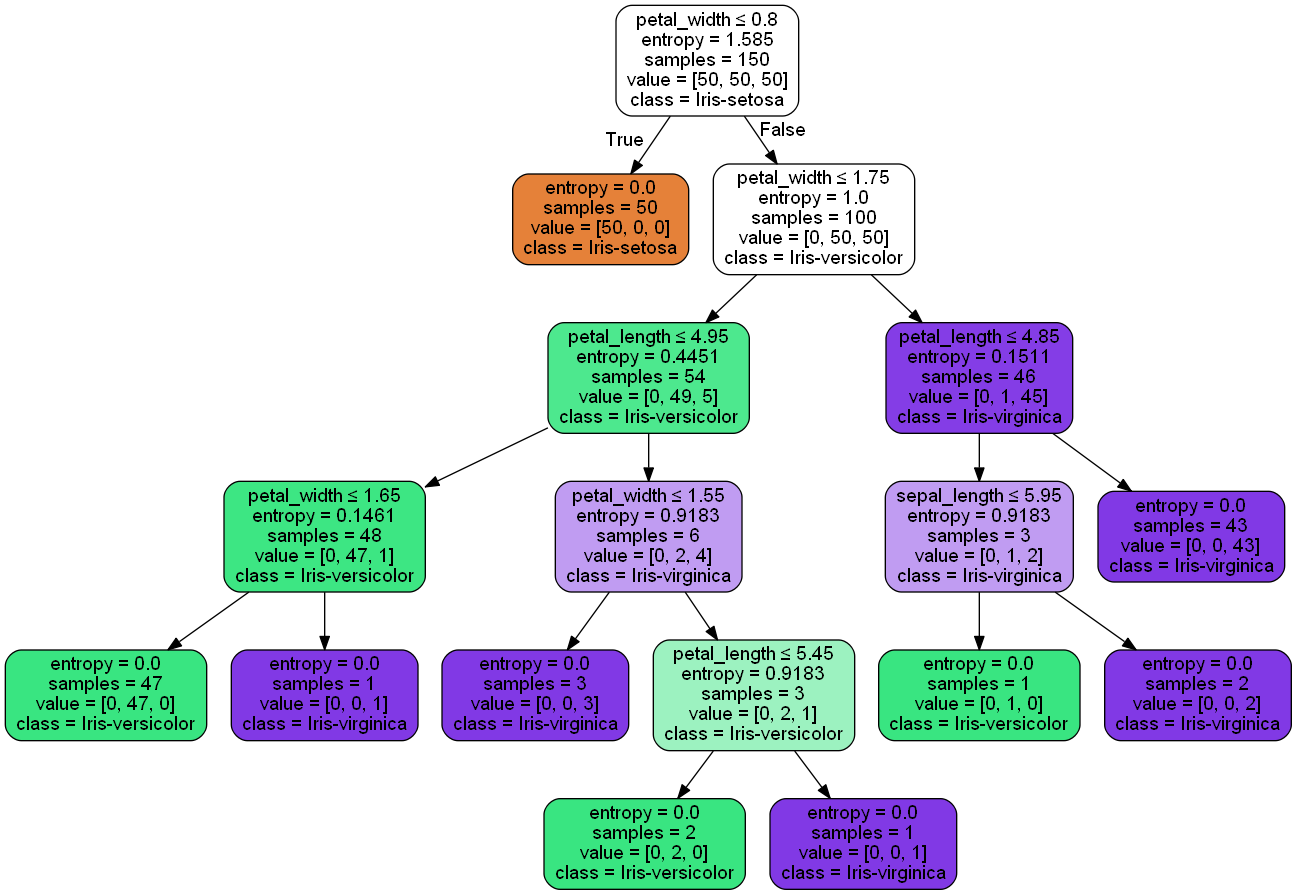

In [6]:
# Display the tree
dot_data = StringIO()  
tree.export_graphviz(model, out_file=dot_data,  
                         feature_names=feature_names,  
                         class_names=classes,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

The tree correctly classifies every example in the training set but it no doubt overfits the data. Let's try the same procedure but hold out a test set.

In [7]:
from sklearn import cross_validation

train_inputs, test_inputs, train_targets, test_targets = cross_validation.train_test_split(inputs, 
                                                                                           targets, 
                                                                                           test_size=0.2)
model.fit(train_inputs, train_targets)

# Make predictions on training and test data
train_predicted = model.predict(train_inputs)
test_predicted = model.predict(test_inputs)

# Summarise model training performance
print(metrics.classification_report(train_targets, train_predicted))
print(metrics.confusion_matrix(train_targets, train_predicted))
print(metrics.accuracy_score(train_targets, train_predicted))

# Summarise model test performance
print(metrics.classification_report(test_targets, test_predicted))
print(metrics.confusion_matrix(test_targets, test_predicted))
print(metrics.accuracy_score(test_targets, test_predicted))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        42
Iris-versicolor       1.00      1.00      1.00        42
 Iris-virginica       1.00      1.00      1.00        36

    avg / total       1.00      1.00      1.00       120

[[42  0  0]
 [ 0 42  0]
 [ 0  0 36]]
1.0
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      1.00      1.00         8
 Iris-virginica       1.00      1.00      1.00        14

    avg / total       1.00      1.00      1.00        30

[[ 8  0  0]
 [ 0  8  0]
 [ 0  0 14]]
1.0


C:\Users\tom\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's try to prevent overfitting by limiting the depth of the tree and use cross validation to find the depth that produces the best generalisation.

We will use accuracy, averaged over the cross validation folds, as the metric to compare models.

In [10]:
# We will compare 5 models, defined by the max depth of the tree
models = [1,2,3,4,5]

# For each model, we will perform a number of cross validation runs
num_cv_iterations = 100

# Each cross validation run will use this number of folds
num_folds = 5

# We will store summary results for each model here
accuracy_summary_per_model = []

for m in models:
    # For the current model, we will temporarily store the score for each fold of each cv run
    accuracy_per_cv_iteration_per_fold = []
    model = DecisionTreeClassifier(criterion='entropy', max_depth=m)
    
    for i in range(num_cv_iterations):
        cv_iterator = cross_validation.KFold(len(inputs), num_folds, shuffle=True)
        scores = cross_validation.cross_val_score(model, inputs, targets, cv=cv_iterator, scoring='accuracy')
        accuracy_per_cv_iteration_per_fold.append(scores)

    # Take the mean across folds for each cv run
    accuracy_per_cv_iteration = np.mean(accuracy_per_cv_iteration_per_fold, axis=1)
    # Summarise across all the cv runs for this model
    accuracy_summary_per_model.append([np.mean(accuracy_per_cv_iteration), np.std(accuracy_per_cv_iteration)])
    
print(accuracy_summary_per_model)

[[0.61253333333333326, 0.020939701791360617], [0.93833333333333346, 0.010514540197058327], [0.94586666666666674, 0.0098106518075451506], [0.94373333333333331, 0.011128342194594831], [0.94380000000000008, 0.01147964381948422]]


A depth of 3 seems to do the trick.  Let's train a model on the full data set and see what it looks like.

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.98      0.94      0.96        50
 Iris-virginica       0.94      0.98      0.96        50

    avg / total       0.97      0.97      0.97       150

[[50  0  0]
 [ 0 47  3]
 [ 0  1 49]]


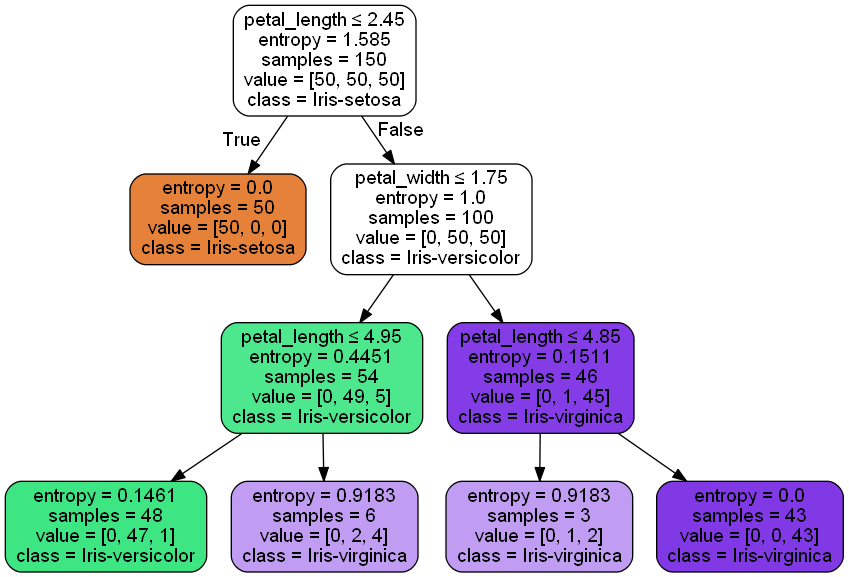

In [11]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(inputs, targets)
predicted = model.predict(inputs)
print(metrics.classification_report(targets, predicted))
print(metrics.confusion_matrix(targets, predicted))

dot_data = StringIO()  
tree.export_graphviz(model, out_file=dot_data,  
                         feature_names=feature_names,  
                         class_names=classes,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

##### Points of interest:

The tree only uses two input features: petal_length and petal_width.

These two features are highly correlated.  Presumably, each feature on its own could produce similar accuracy.

Petal length and width are also both highly correlated with sepal length, explaining why sepal length is not useful in constructing the tree.

From the scatter plots of sepal_length versus petal_length and petal_width, it is apparent that the best decision boundary between the non-linearly separable classes is close to vertical.  A further indication that the sepal length feature adds no discriminatory power.

A similar argument can be made for sepal width.  While it is not strongly correlated with the other features, it does not help to distinguish the 2 non-linearly separable classes - they have very similar sepal widths.

##### Further work

Try regularising the tree with some of the other hyperparameters (max_features=None, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0).

Could a random forest give better accuracy without overfitting?

Try a different model (logistic regression, MLP, SVM, ...)